In [44]:
import numpy as np
import torch
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim

from PIL import Image
from torch import nn
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

print(torch.__version__)

2.3.0+cu118


In [53]:
class CustomImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, csv_file, transform=None, target_transform=None):
        self.root = root
        self.df = pd.read_csv(csv_file, header=0, on_bad_lines='skip')
        self.transform = transform
        self.target_transform = target_transform
        self.num_classes = 19

    def parse_labels(self, label_str):
        label_array = [0] * self.num_classes

        label_list = label_str.split()
        for label in label_list:
            index = int(label) - 1
            label_array[index] = 1

        return torch.tensor(label_array, dtype=torch.float)

    def __getitem__(self, index):
        img_path = os.path.join(self.root, self.df.iloc[index, 0])
        label_str = self.df.iloc[index, 1] 

        img = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        label = self.parse_labels(label_str)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

    def __len__(self):
        return len(self.df)
    
root = "COMP5329S1A2Dataset/data"
csv_file = "COMP5329S1A2Dataset/train.csv"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

dataset = CustomImageFolder(root=root, csv_file=csv_file, transform=transform)

batch_size = 32

test_queue = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=0
)

print(len(test_queue))

938


Sample 0
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


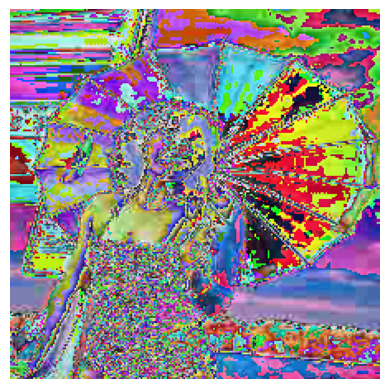

Sample 1
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.])


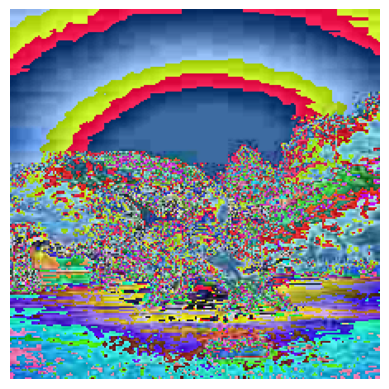

Sample 2
Image shape: torch.Size([3, 224, 224])
Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


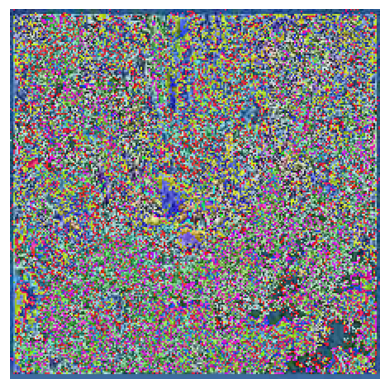

Sample 3
Image shape: torch.Size([3, 224, 224])
Label: tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.])


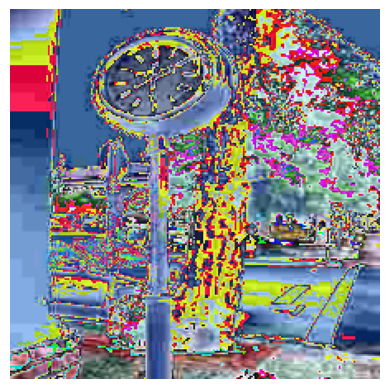

Sample 4
Image shape: torch.Size([3, 224, 224])
Label: tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


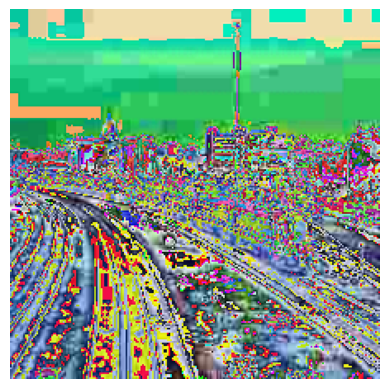

In [46]:
for i in range(5):
    sample = dataset[i]
    print("Sample", i)
    print("Image shape:", sample[0].shape)
    print("Label:", sample[1])
    image = TF.to_pil_image(sample[0])
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

In [47]:
# label_counts = {}

# for sample in dataset:
#     labels = sample[1]
#     for label in labels:
#         if label not in label_counts:
#             label_counts[label] = 1 
#         else:
#             label_counts[label] += 1 

# for label, count in label_counts.items():
#     print("label:", label, "count:", count)

In [48]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=18, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet, self).__init__()

        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv2d(3, 64, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-pooling
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling
        x = self.avgpool(x)
        # flat the feature map
        x = torch.flatten(x, start_dim=1)
        # classification
        x = self.classifier(x)

        return x

    # back-propagation is handled by PyTorch

In [49]:
def multilabel_accuracy(output, target, threshold=0.5):

    prob = torch.sigmoid(output)

    pred = (prob >= threshold).float()
    
    correct = (pred == target).float()
    batch_accuracy = correct.mean().item()
    
    return batch_accuracy

In [55]:
model = AlexNet(num_classes=19, stem_stride=1)
learning_rate = 0.1
epochs = 3
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')
else:
    print('using CPU')

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

# define loss function
criterion = nn.BCEWithLogitsLoss()

model.train()

print("=========== train start ===========")

for ep in range(epochs):
    ep_loss = 0.0
    ep_acc = 0.0
    for step, (x, y) in enumerate(test_queue):
        if torch.cuda.is_available():
            x = x.to('cuda')
            y = y.to('cuda')
        # set gradient to zero
        optimizer.zero_grad()
        # calculate output
        p = model(x)
        # calculate metrics
        loss = criterion(p, y)
        acc = multilabel_accuracy(p, y)
        ep_loss += loss.item()
        ep_acc += acc
        # back-prop
        loss.backward()
        # update parameters
        optimizer.step()

        if step % 32 == 0:
            print('\repoch: %d step: %d loss: %.2f acc: %.4f'
                    % (ep, step, ep_loss/(step+1), ep_acc/(step+1)), end='')

    print('\nepoch: %d loss: %.2f acc: %.4f'
          % (ep, ep_loss/(step+1), ep_acc/(step+1)))

using GPU
=========== train start ===========
epoch: 0 step: 0 loss: 0.70 acc: 0.3421